In [1]:
using PyPlot

In [ ]:
show(plot(randn(10,1),randn(10,1)))


In [2]:
#workspace() # needed for redefining type
type State
    position::Int
    spin::Array{Any,2}
    State() = new(0,[1 0]')
    State(position,spin) = new(position,spin)
end

type TwoState
    sa::State
    sb::State
    #amps::Array{Any,4}
    #TwoState() = new(State(),State(),[]
end

type TSexpanded
    spina::Int
    spinb::Int
    posa::Int
    posb::Int
    amp::Float64
    TSexpanded()=new()
    TSexpanded(spina,spinb,posa,posb,amp) = new(spina,spinb,posa,posb,amp)
end

convert(::Type{Int}, x::State) = x.position
promote_rule(::Type{State}, ::Type{Int}) = Int
convert(::Type{Array{Any,2}}, x::State) = x.spin
promote_rule(::Type{State}, ::Type{Array{Any,2}}) = Array{Any,2}
convert(x::Type{State}, ::Array{State,1}) = x
promote_rule(::Type{State}, ::Type{Array{State,1}}) = State

promote_rule (generic function with 3 methods)

In [3]:
function walk(Coin,InState)
    #Figure out default initialization
    Lstate=State(0,[0 0])
    Rstate=State(0,[0 0])
    nstate = C*InState.spin
    Lstate.position = InState.position - 1
    Rstate.position = InState.position + 1
    Lstate.spin = [nstate[1] 0]'
    Rstate.spin = [0 nstate[2]]'
    return [Lstate, Rstate]
end

function tspinup(Coin,InState)
    #Figure out default initialization
    Lstate=State(0,[0 0])
    Rstate=State(0,[0 0])
    nstate = Coin*InState.spin
    Lstate.position = InState.position
    Rstate.position = InState.position + 1
    Lstate.spin = [nstate[1] 0]'
    Rstate.spin = [0 nstate[2]]'
    return [Lstate, Rstate]    
end

function tspindown(Coin,InState)
    #Figure out default initialization
    Lstate=State(0,[0 0])
    Rstate=State(0,[0 0])
    nstate = Coin*InState.spin
    Lstate.position = InState.position - 1
    Rstate.position = InState.position
    Lstate.spin = [nstate[1] 0]'
    Rstate.spin = [0 nstate[2]]'
    return [Lstate, Rstate]    
end

function R(theta)
    return [cos(theta/2) -sin(theta/2);
            sin(theta/2) cos(theta/2)]
end

function walkarrayf(Coin,s1::Array{State,1},f::Function)
    S = State(0,[0 0]')
    for ii in 1:1:length(s1)
            Snew = f(Coin,s1[ii])
        for jj = 1:1:length(Snew)
            S = S + Snew[jj]
        end
    end
    return S
end

function walkarrayf_disorder(theta,s1::Array{State,1},f::Function,ds)
    S = State(0,[0 0]')
    for ii in 1:1:length(s1)
            r = 2*ds*pi*rand(1)-ds*pi
            Coin = R(theta + r)
            Snew = f(Coin,s1[ii])
        for jj = 1:1:length(Snew)
            S = S + Snew[jj]
        end
    end
    return S
end

walkarrayf_disorder (generic function with 1 method)

In [4]:
function +(s1::State, s2::State)
    #Linear combination
    if s1.position == s2.position
        s=State(s1.position,s2.spin+s1.spin)
        #return [s, State(0,[0 0]')]
        return s
    else
        return [s1,s2]
    end
end

function -(s1::State, s2::State)
    #Linear combination
    if s1.position == s2.position
        s=State(s1.position,s2.spin-s1.spin)
        #return [s, State(0,[0 0]')]
        return s
    else
        return [s1,s2]
    end
end

function +(s1::Array{State,1}, s2::State)
    #Linear combination
    s = s1
    for ii in 1:1:length(s1)
        if s1[ii].position == s2.position
            #s=State(s1[ii].position,s2.spin+s1[ii].spin)
            #return [s, State(0,[0 0]')]
            s[ii]=s1[ii] + s2
            return s
        end
    end
    #if length(s) == length(s1)
    #    return s
    #else
    return [s1,s2]
   # end
end

function +(s1::Array{State,1}, s2::Array{State,1})
    s = s1
    #print(s1,"\n")
    #print(s2[1])
    for ii in 1:1:length(s2)
        for jj in 1:1:length(s1)
            #print(s2[ii])
            #print(s1[jj])
            #if(length(s1[jj] + s2[ii]))>1
                #s=vcat(s,s2[ii])
            #if length(s1[jj] + s2[ii])==1
                s=vcat(s,s1[jj] + s2[ii])
            #end
        end
    end
    #if length(s) == length(s1)
    #    return s
    #else
    #    return [s1,s2]
   # end
    return s
end

function ==(s1::State, s2::State)
    if s1.position == s2.position && s1.spin[1] == s2.spin[1] && s1.spin[2] == s2.spin[2]
        return true
    else
        return false
    end
end

function *(s1::State, s2::State)
    #Tensor product
    m11 = TSexpanded()
    m12 = TSexpanded()
    m21 = TSexpanded()
    m22 = TSexpanded()
    
    m11.spina = 0
    m11.spinb = 0
    m11.posa = s1.position
    m11.posb = s2.position
    m11.amp = s1.spin[1]*s2.spin[1]
    
    m12.spina = 0
    m12.spinb = 1
    m12.posa = s1.position
    m12.posb = s2.position
    m12.amp = s1.spin[1]*s2.spin[2]
    
    m21.spina = 1
    m21.spinb = 0
    m21.posa = s1.position
    m21.posb = s2.position
    m21.amp = s1.spin[2]*s2.spin[1]
    
    m22.spina = 1
    m22.spinb = 1
    m22.posa = s1.position
    m22.posb = s2.position
    m22.amp = s1.spin[2]*s2.spin[2]
    
    return [m11,m12,m21,m22]
end


function *(s1::Array{State,1}, s2::State)
    #Tensor product
    s = []
    for ii in 1:1:length(s1)
        s=vcat(s,s1[ii]*s2) 
    end
    return s
end

function *(s1::Array{State,1}, s2::Array{State,1})
    #Tensor product
    s = []
    for ii in 1:1:length(s1)
        for jj in 1:1:length(s2)
            s=vcat(s,s1[ii]*s2[jj])
        end
    end
    return s
end

function +(s1::TSexpanded, s2::TSexpanded)
    #Linear combination of Two state system
    if s1.posa == s2.posa && s1.posb == s2.posb && s1.spina == s2.spina && s1.spinb == s2.spinb
        return s = TSexpanded(s1.spina,s1.spinb,s1.posa,s1.posb,s1.amp+s2.amp)
    else
        return [s1,s2]
    end
end

function -(s1::TSexpanded, s2::TSexpanded)
    #Linear combination of Two state system
    if s1.posa == s2.posa && s1.posb == s2.posb && s1.spina == s2.spina && s1.spinb == s2.spinb
        return s = TSexpanded(s1.spina,s1.spinb,s1.posa,s1.posb,s1.amp-s2.amp)
    else
        return [s1,s2]
    end
end

function +(s1::Array{TSexpanded,1}, s2::TSexpanded)
    #Linear combination of Two state system
    s = s1
    for ii in 1:1:length(s1)
        if s1[ii].posa == s2.posa && s1[ii].posb == s2.posb && s1[ii].spina == s2.spina && s1[ii].spinb == s2.spinb
             s[ii] = TSexpanded(s1[ii].spina,s1[ii].spinb,s1[ii].posa,s1[ii].posb,s1[ii].amp+s2.amp)
            return s
        end
    end
            return [s,s2]
end

function -(s1::Array{TSexpanded,1}, s2::TSexpanded)
    #Linear combination of Two state system
    s = s1
    for ii in 1:1:length(s1)
        if s1[ii].posa == s2.posa && s1[ii].posb == s2.posb && s1[ii].spina == s2.spina && s1[ii].spinb == s2.spinb
             s[ii] = TSexpanded(s1[ii].spina,s1[ii].spinb,s1[ii].posa,s1[ii].posb,s1[ii].amp-s2.amp)
            return s
        end
    end
            return [s,s2]
end

function +(s1::Array{TSexpanded,1}, s2::Array{TSexpanded,1})
    #Linear combination of Two state system
    s = s1
    for ii in 1:1:length(s2)
        s = s + s2[ii]
    end
    return s
end

function -(s1::Array{TSexpanded,1}, s2::Array{TSexpanded,1})
    #Linear combination of Two state system
    s = s1
    for ii in 1:1:length(s2)
        s = s - s2[ii]
    end
    return s
end

function *(s1::Float64, s2::Array{TSexpanded,1})
    #Multiplication by scalar
    for ii in 1:1:length(s2)
        s2[ii].amp =  s2[ii].amp*s1
    end
    return s2
end

function .*(s1::Float64, s2::TSexpanded)
    #Multiplication by scalar
    s2.amp =  s2.amp*s1
    return s2
end

function rho(psi::Array{TSexpanded,1})
    #Density Matrix from Two State system
    a = []
    for ii in 1:1:length(psi)
        a = vcat(a,psi[ii].amp)
    end
    return a*a'
end

#function reducedrho(Sab::Array{TSexpanded,1})
function reducedrho(Sab::Array{Any,1})
    #reduced density matrix, trace out spatial DOF    
    spina = [s.spina for s in Sab]
    Suu = Sab[find( spina -> spina == 1,spina)]
    spinb = [s.spinb for s in Suu]
    Suu = Suu[find( spinb -> spinb == 1,spinb)]
    ampuu = sum([s.amp for s in Suu])

    Sdu = Sab[find( spina -> spina == 0,spina)]
    spinb = [s.spinb for s in Sdu]
    Sdu = Sdu[find( spinb -> spinb == 1,spinb)]
    ampdu = sum([s.amp for s in Sdu])

    Sdd = Sab[find( spina -> spina == 0,spina)]
    spinb = [s.spinb for s in Sdd]
    Sdd = Sdd[find( spinb -> spinb == 0,spinb)]
    ampdd = sum([s.amp for s in Sdd])

    Sud = Sab[find( spina -> spina == 1,spina)]
    spinb = [s.spinb for s in Sud]
    Sud = Sud[find( spinb -> spinb == 0,spinb)]
    ampud = sum([s.amp for s in Sud])

    redrho = [ampuu,ampdu,ampud,ampdd]
    redrho = redrho*redrho'
    return redrho
end

function ==(s1::TwoState, s2::TwoState)
    if s1.sa == s2.sa && s1.sb == s2.sb
        return true
    else
        return false
    end
end

function Base.(:(+))(s1::TwoState, s2::TwoState)
    if s1 == s2
        s = TwoState(s1.sa + s2.sa, s1.sb + s2.sb)
    else
        return [s1,s2]
    end
end

function -(s1::TwoState, s2::TwoState)
    if s1 == s2
        s = TwoState(s1.sa - s2.sa, s1.sb - s2.sb)
    else
        return [s1,s2]
    end
end

function probspat(Sab)
    
maxa = maximum([s.posa for s in Sab])
mina = minimum([s.posa for s in Sab])
maxb = maximum([s.posb for s in Sab])
minb = minimum([s.posb for s in Sab])
amp = complex(zeros(length([mina:1:maxa]),length([mina:1:maxa])))
ci = 0
cj = 0
for ii in mina:1:maxa
    ci = ci + 1
    for jj in minb:1:maxb
        cj = cj + 1
        posa = [s.posa for s in Sab]
        pos=Sab[find( posa -> posa == ii,posa)]
        posb = [s.posb for s in pos]
        pos=pos[find( posb -> posb == jj,posb)]
        #amp = vcat(amp,sum([s.amp for s in pos]))
        amp[ci,cj] = sum([s.amp for s in pos]).^2
    end
    cj = 0
end
    
    return amp
end

probspat (generic function with 1 method)

In [ ]:
#two particle split step
n = 10
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
#################################
#Make C1,C2 different for a and b
#################################
C1 = R(-pi/2)
C2 = R(3*pi/4)
for ii in 1:1:n
    Sa = walkarrayf(C1,Sa,tspinup)
    Sa = walkarrayf(C2,Sa,tspindown)
    Sb = walkarrayf(C1,Sb,tspinup)
    Sb = walkarrayf(C2,Sb,tspindown)
end
#Sa

In [ ]:
Sab = Sa*Sb
maxa = maximum([s.posa for s in Sab])
mina = minimum([s.posa for s in Sab])
maxb = maximum([s.posb for s in Sab])
minb = minimum([s.posb for s in Sab])
amp = complex(zeros(length([mina:1:maxa]),length([mina:1:maxa])))
ci = 0
cj = 0
for ii in mina:1:maxa
    ci = ci + 1
    for jj in minb:1:maxb
        cj = cj + 1
        posa = [s.posa for s in Sab]
        pos=Sab[find( posa -> posa == ii,posa)]
        posb = [s.posb for s in pos]
        pos=pos[find( posb -> posb == jj,posb)]
        #amp = vcat(amp,sum([s.amp for s in pos]))
        amp[ci,cj] = sum([s.amp for s in pos]).^2
    end
    cj = 0
end
#amp

In [ ]:
#using PyPlot
logamp = log(real(amp))
X=repmat([mina:1:maxa],1,length([mina:1:maxa]))
Y=repmat([minb:1:maxb]',length([minb:1:maxb]),1)
fig = figure("pyplot_surfaceplot",figsize=(6,6))
ax = fig[:add_subplot](1,1,1, projection = "3d")
ax[:plot_surface](X,Y,logamp)
#ax[:set_zlim]([0,10e-3])
savefig("plot.svg")

In [ ]:
#using PyPlot
logamp = log(real(amp))
X=repmat([mina:1:maxa],1,length([mina:1:maxa]))
Y=repmat([minb:1:maxb]',length([minb:1:maxb]),1)
fig = figure("pyplot_surfaceplot",figsize=(6,6))
ax = fig[:add_subplot](1,1,1, projection = "3d")
ax[:plot_surface](X,Y,real(amp))
#ax[:set_zlim]([0,10e-3])
savefig("plot2.svg")



In [ ]:
matshow(real(amp),cmap="Accent")

In [ ]:
u = [s.spin[1] for s in Sa]
d = [s.spin[2] for s in Sa]
plot(u)
plot(d)

In [ ]:
#hadamaard walk
n = 3
Sa = [State(0,[1 0]')]
C = 1/sqrt(2)*[1 1;
     1 -1]
St = []
for ii in 1:1:n
    Sa = walkarrayf(C,Sa,walk)
    print(Sa)
    print("\n")
    
end

In [5]:
function probtwo_sep(Sa,Sb)
    u = [s.spin[1] for s in Sa]
    d = [s.spin[2] for s in Sa]
    p = [s.position for s in Sa]
    v = sortperm(p)
    a = u[v].^2 + d[v].^2
    u = [s.spin[1] for s in Sb]
    d = [s.spin[2] for s in Sb]
    p = [s.position for s in Sb]
    v = sortperm(p)
    b = u[v].^2 + d[v].^2
    return a*b'
end

function probtwo_ent(Sa,Sb,Sa2,Sb2)
    u = [s.spin[1] for s in Sa]
    d = [s.spin[2] for s in Sa]
    p = [s.position for s in Sa]
    v = sortperm(p)
    ua1 = u[v]
    da1 = d[v]
    a = u[v].^2 + d[v].^2
    u = [s.spin[1] for s in Sb]
    d = [s.spin[2] for s in Sb]
    p = [s.position for s in Sb]
    v = sortperm(p)
    ub1 = u[v]
    db1 = d[v]
    b = u[v].^2 + d[v].^2
    p1 = a*b'
    
    u = [s.spin[1] for s in Sa2]
    d = [s.spin[2] for s in Sa2]
    p = [s.position for s in Sa2]
    v = sortperm(p)
    ua2 = u[v]
    da2 = d[v]
    a = u[v].^2 + d[v].^2
    u = [s.spin[1] for s in Sb2]
    d = [s.spin[2] for s in Sb2]
    p = [s.position for s in Sb2]
    v = sortperm(p)
    ub2 = u[v]
    db2 = d[v]
    b = u[v].^2 + d[v].^2
    p2 = a*b'
    
    p = zeros(size(p1,1),size(p1,2))
    for ii in 1:1:size(p1,1)
        for jj in 1:1:size(p1,2)
            p[ii,jj]= 0.5*(p1[ii,jj]+ p2[ii,jj])+ua1[ii]*db1[ii]*ub2[jj]*da2[jj]+ua2[jj]*db2[jj]*ub1[ii]*da1[ii]
        end
    end
    return p
end

probtwo_ent (generic function with 1 method)

In [41]:
#hadamaard walk
n = 100
Sa = [State(0,[1 0]')]
C = 1/sqrt(2)*[1 1;
     1 -1]
St = []
for ii in 1:1:n
    Sa = walkarrayf(C,Sa,walk)
    spin = [s.spin for s in Sa]
    rhoC = zeros(2,2)
    #print(size(spin,1))
    for jj = 1:1:size(spin,1)
        #print(spin[jj])
        rhoC = rhoC + float64(spin[jj]*spin[jj]')
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log2(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end
#Sa

In [77]:
#two particle hadamaard walk
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
C = 1/sqrt(2)*[1 1;
     1 -1]
St = []
Cr = []
Sab = []
for ii in 1:1:n
    Cr = R(2*rand(1))*C*R(2*rand(1))'
    Sa = walkarrayf(Cr,Sa,walk)
    Cr = R(2*rand(1))*C*R(2*rand(1))'
    Sb = walkarrayf(Cr,Sb,walk)
    Cr = R(2*rand(1))*C*R(2*rand(1))'
    Sa2 = walkarrayf(Cr,Sa2,walk)
    Cr = R(2*rand(1))*C*R(2*rand(1))'
    Sb2 = walkarrayf(Cr,Sb2,walk)
    #Sa =  walkarrayf_disorder(pi/2,Sa,walk,2)
    #Sb =  walkarrayf_disorder(pi/2,Sb,walk,2)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    
    u = [s.spin[1] for s in Sa]
    d = [s.spin[2] for s in Sa]
    p = [s.position for s in Sa]
    v = sortperm(p)
    u[v].^2 + d[v].^2
    #Sab = (Sa*Sb)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log2(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end
#Sa

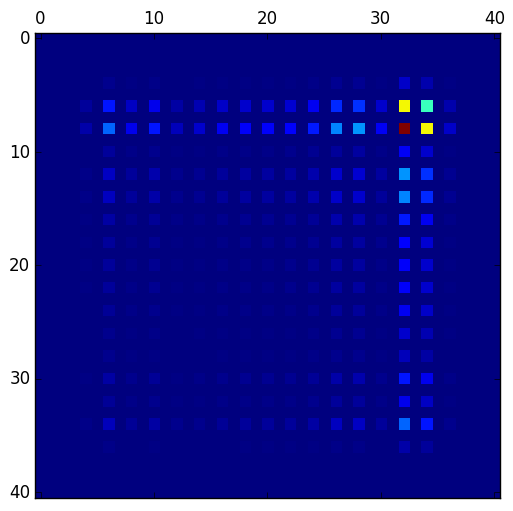

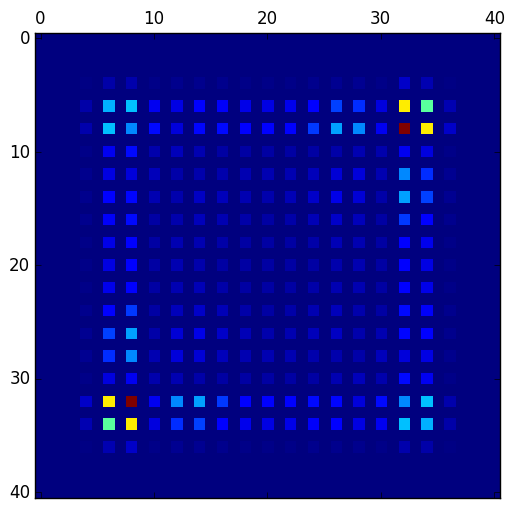

PyObject <matplotlib.image.AxesImage object at 0x3161efc90>

In [97]:
amp=probtwo_sep(Sa,Sb)
matshow(real(amp))
#amp=probtwo_sep(Sa2,Sb2)
#matshow(real(amp))
amp=probtwo_ent(Sa,Sb,Sa2,Sb2)
matshow((amp))

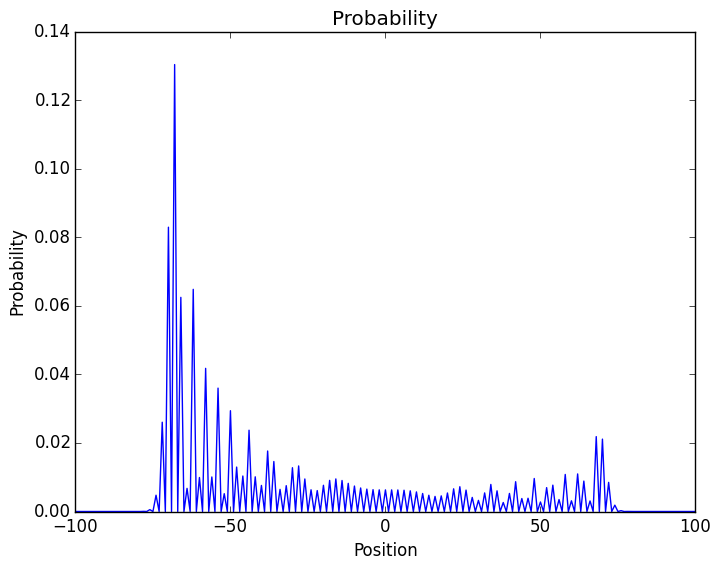

In [42]:
u = [s.spin[1] for s in Sa]
d = [s.spin[2] for s in Sa]
p = [s.position for s in Sa]
v = sortperm(p)
#plot(p[v],u[v])
#plot(p[v],d[v])
plot(p[v],u[v].^2 + d[v].^2)
title("Probability")
xlabel("Position")
ylabel("Probability")
savefig("Probability_hadamard.pdf")

In [44]:
R(pi/2)

2x2 Array{Float64,2}:
 0.707107  -0.707107
 0.707107   0.707107

In [ ]:
#two particle split step
n = 10
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
#################################
#Make C1,C2 different for a and b
#################################
C1 = R(-pi/2)
C2 = R(3*pi/4)
for ii in 1:1:n
    Sa = walkarrayf(C1,Sa,tspinup)
    Sa = walkarrayf(C2,Sa,tspindown)
    Sb = walkarrayf(C1,Sb,tspinup)
    Sb = walkarrayf(C2,Sb,tspindown)
end

Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1 = R(-pi/2)
C2 = R(3*pi/4)
for ii in 1:1:n
    Sa2 = walkarrayf(C1,Sa2,tspinup)
    Sa2 = walkarrayf(C2,Sa2,tspindown)
    Sb2 = walkarrayf(C1,Sb2,tspinup)
    Sb2 = walkarrayf(C2,Sb2,tspindown)
end
Sab = Sa*Sb + Sa2*Sb2

In [ ]:
function rho(psi::Array{Any,1})
    a = []
    for ii in 1:1:length(psi)
        a=vcat(a,psi[ii].amp)
    end
    return float64(a*a')
end
rho(Sab)

In [ ]:
trace(0.5*(rho(Sab)))

In [ ]:
convert(Array{Float64,2}, (rho(Sab)))

In [ ]:
#two particle split step
n = 50
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(-pi/2)
C2a = R(3*pi/4)
C1b = R(0)
C2b = R(0)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end


In [ ]:
lambda = eigvals(rhoC)

In [ ]:
Sl = lambda.*log(abs(lambda))
sum(Sl[!isnan(Sl)])

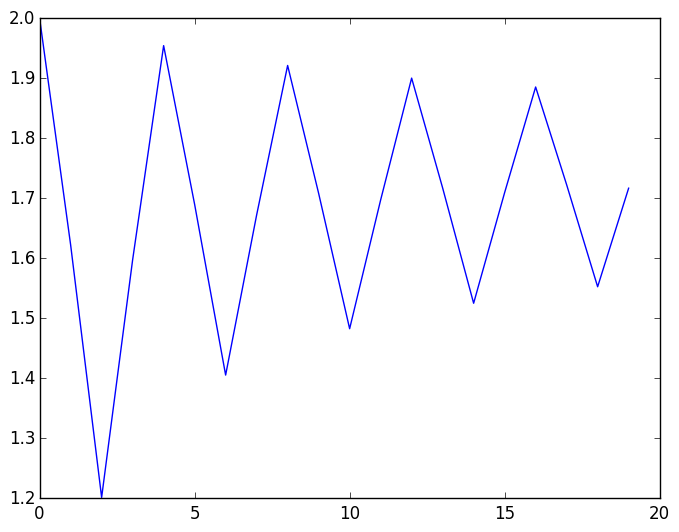

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31290d850>

In [54]:
plot(St)

In [ ]:
#two particle split step
n = 50
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(-pi/2)
C2a = R(3*pi/4)
C1b = R(-pi/2+.1)
C2b = R(3*pi/4+.1)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    #print(trace(rhoC))
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end


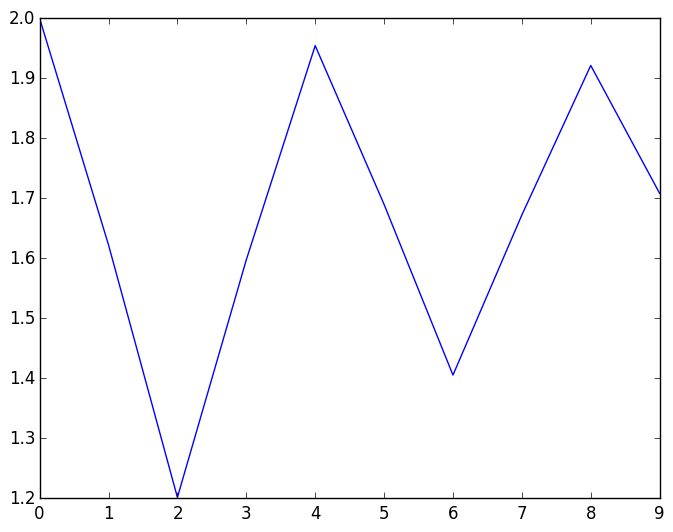

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x313948d10>

In [39]:
plot(St)

In [7]:
#two particle split step
n = 50
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
#C1a = R(-pi/2)
#C2a = R(3*pi/4)
#C1b = R(-pi/2)
#C2b = R(0)
C1a = R(-pi/2)
C2a = R(pi/4)
C1b = R(-pi/2)
C2b = R(3*pi/4)
#Stp = []
St = []
ds = 2
for ii in 1:1:n
    #Sa = walkarrayf(C1a,Sa,tspinup)
    #Sa = walkarrayf(C2a,Sa,tspindown)
    #Sb = walkarrayf(C1b,Sb,tspinup)
    #Sb = walkarrayf(C2b,Sb,tspindown)
    #Sa2 = walkarrayf(C1a,Sa2,tspinup)
    #Sa2 = walkarrayf(C2a,Sa2,tspindown)
    #Sb2 = walkarrayf(C1b,Sb2,tspinup)
    #Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sb = walkarrayf_disorder(-pi/2,Sb,tspinup,ds)
    Sb = walkarrayf_disorder(pi/4,Sb,tspindown,ds)
    Sa = walkarrayf_disorder(-pi/2,Sa,tspinup,ds)
    Sa = walkarrayf_disorder(3*pi/4,Sa,tspindown,ds)
    Sb2 = walkarrayf_disorder(-pi/2,Sb2,tspinup,ds)
    Sb2 = walkarrayf_disorder(pi/4,Sb2,tspindown,ds)
    Sa2 = walkarrayf_disorder(-pi/2,Sa2,tspinup,ds)
    Sa2 = walkarrayf_disorder(3*pi/4,Sa2,tspindown,ds)
    #Sab = (Sa*Sb)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    #print(trace(rhoC))
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    #Stp = vcat(Stp,sum(Sl[!isnan(Sl)]))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end


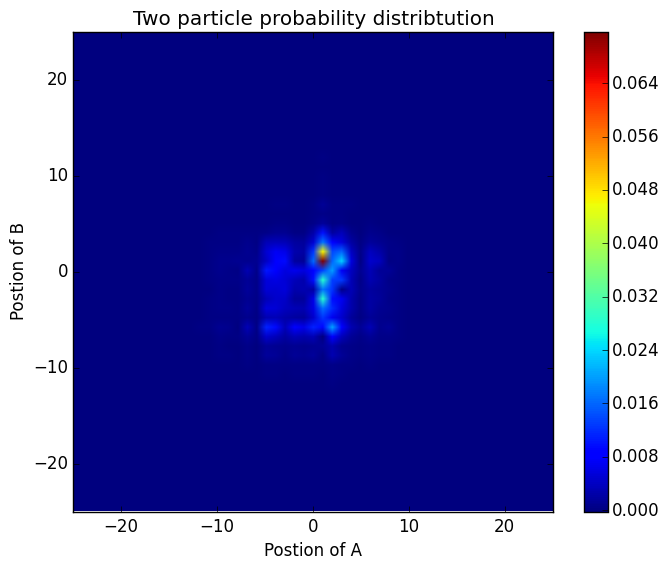

In [28]:
#amp=probtwo_sep(Sa,Sb)
#matshow(real(amp))
#amp=probtwo_sep(Sa2,Sb2)
#matshow(real(amp))
amp=probtwo_ent(Sa,Sb,Sa2,Sb2)
#matshow((amp))


maxa = maximum([s.position for s in Sa])
mina = minimum([s.position for s in Sa])
maxb = maximum([s.position for s in Sb])
minb = minimum([s.position for s in Sb])
fig, ax = subplots()
#N=length(t1a)
img = ax[:imshow](amp,extent=[mina, maxa, minb, maxb])
xlabel("Postion of A") 
ylabel("Postion of B")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
#ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
#ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title("Two particle probability distribtution")
savefig("TwoPartProb_disorder.pdf")

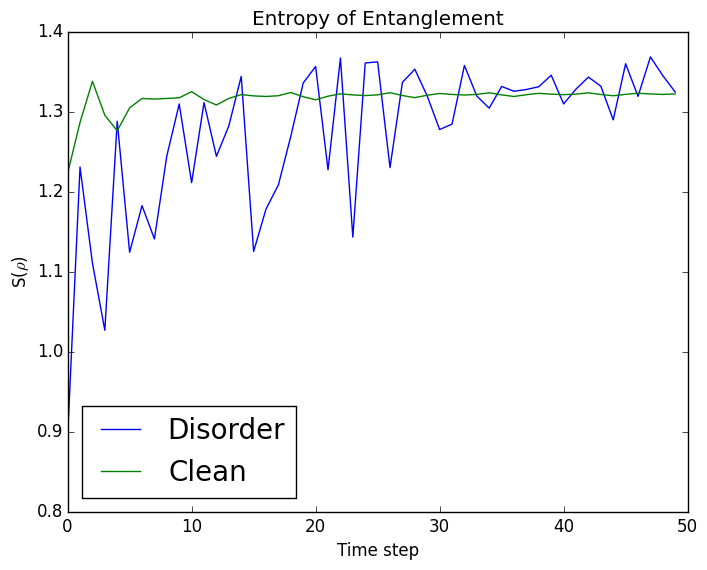

In [9]:
fig, ax = subplots()
#ax[:plot](rand(10), rand(10), label = "Data")
ax[:plot](St,label = "Disorder")
ax[:plot](Stp,label = "Clean")
title("Entropy of Entanglement")
xlabel("Time step")
ylabel(L"S($\rho$)")
ax[:legend](loc="best", fontsize=20)
savefig("EntropyofEntanglement_twoparticle_comparision.pdf")


In [ ]:
#loop through two particle split step walk
t1a = [0 0 pi/2 0 0 -pi/2] 
t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
t1b = [0 0 pi/2 pi/2 0 -pi/2]
t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a))

for kk in 1:1:length(t1a)
n = 25
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(t2a[kk])
C1b = R(t1b[kk])
C2b = R(t2b[kk])
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk] = mean(St)
    
end



In [ ]:
Stt

In [ ]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:0.2:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a))

for kk in 1:1:length(t1a)
n = 25
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(pi/4)
C1b = R(0)
C2b = R(pi/2)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk] = mean(St)
    
end



In [ ]:
plot(t1a,Stt)
xlabel(L"$\theta_1$") 
ylabel(L"S($ \rho$)")
title("Entropy of Entanglement")
savefig("EntropyofEntanglementT2pi_4.pdf")

In [ ]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:0.2:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a))

for kk in 1:1:length(t1a)
n = 25
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(pi/2)
C1b = R(0)
C2b = R(pi/2)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk] = mean(St)
    
end



In [ ]:
plot(t1a,Stt)
xlabel(L"$\theta_1$") 
ylabel(L"S($ \rho$)")
title("Entropy of Entanglement")
savefig("EntropyofEntanglementT2pi_2.pdf")

In [ ]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(t2a[ll])
C1b = R(0)
C2b = R(pi/2)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end

In [ ]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title(L"Entropy of Entanglement $\theta_{1b}=0$ $\theta_{2b}=\pi/2$ ")
savefig("EntropyofEntanglementZ20.pdf")

In [ ]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(t2a[ll])
C1b = R(pi/2)
C2b = R(0)
St = []
for ii in 1:1:n
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end

In [ ]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title(L"Entropy of Entanglement $\theta_{1b}=\pi/2$ $\theta_{2b}=0$ ")
savefig("EntropyofEntanglementZ21.pdf")

In [9]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################
C1a = R(t1a[kk])
C2a = R(t2a[ll])
St = []
for ii in 1:1:n
    #r = 2*pi*rand(1)-pi
            C1b = R(-pi/2)
            C2b = R(3*pi/4)
    #C1b = R(4*pi*rand(1)-2*pi)
    #C2b = R(4*pi*rand(1)-2*pi)
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = (Sa*Sb)
    #Sab = 1/sqrt(2).*(Sa*Sb) + 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end

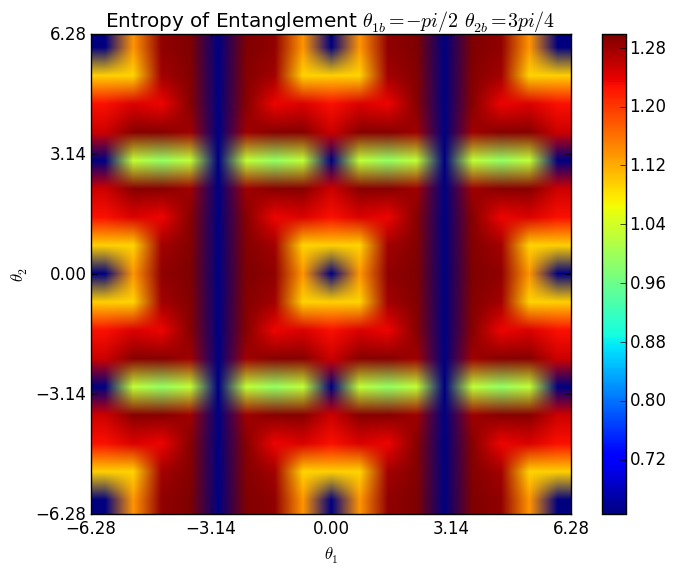

In [10]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title(L"Entropy of Entanglement $\theta_{1b}=-pi/2$ $\theta_{2b}=3pi/4$ ")
savefig("EntropyofEntanglement_sep2.pdf")

In [ ]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################

St = []
for ii in 1:1:n
    #r = 2*pi*rand(1)-pi
    C1a = R(t1a[kk]+0.2*pi*rand(1)-0.1*pi)
    C2a = R(t2a[ll]+0.2*pi*rand(1)-0.1*pi)
    C1b = R(4*pi*rand(1)-2*pi)
    C2b = R(4*pi*rand(1)-2*pi)
    Sa = walkarrayf(C1a,Sa,tspinup)
    Sa = walkarrayf(C2a,Sa,tspindown)
    Sb = walkarrayf(C1b,Sb,tspinup)
    Sb = walkarrayf(C2b,Sb,tspindown)
    Sa2 = walkarrayf(C1a,Sa2,tspinup)
    Sa2 = walkarrayf(C2a,Sa2,tspindown)
    Sb2 = walkarrayf(C1b,Sb2,tspinup)
    Sb2 = walkarrayf(C2b,Sb2,tspindown)
    Sab = 1/sqrt(2).*(Sa*Sb) - 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end

In [ ]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title(L"Entropy of Entanglement $\theta_{1b}=0+p$ $\theta_{2b}=0+p$ ")
savefig("EntropyofEntanglementZ21_disorder6.pdf")

In [21]:
#loop through two particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
Sa2 = [State(0,[0 1]')]
Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################

#C1a = R(t1a[kk])
#C2a = R(t2a[ll])
St = []
for ii in 1:1:n
    #C1b = R(4*pi*rand(1)-2*pi)
    #C2b = R(4*pi*rand(1)-2*pi)
    Sb = walkarrayf_disorder(0,Sb,tspinup,2)
    Sb = walkarrayf_disorder(0,Sb,tspindown,2)
    Sa = walkarrayf_disorder(t1a[kk],Sa,tspinup,2)
    Sa = walkarrayf_disorder(t2a[ll],Sa,tspindown,2)
    Sb2 = walkarrayf_disorder(0,Sb2,tspinup,2)
    Sb2 = walkarrayf_disorder(0,Sb2,tspindown,2)
    Sa2 = walkarrayf_disorder(t1a[kk],Sa2,tspinup,2)
    Sa2 = walkarrayf_disorder(t2a[ll],Sa2,tspindown,2)
    #Sa = walkarrayf(C1a,Sa,tspinup)
    #Sa = walkarrayf(C2a,Sa,tspindown)
    #Sb = walkarrayf(C1b,Sb,tspinup)
    #Sb = walkarrayf(C2b,Sb,tspindown)
    #Sa2 = walkarrayf(C1a,Sa2,tspinup)
    #Sa2 = walkarrayf(C2a,Sa2,tspindown)
    #Sb2 = walkarrayf(C1b,Sb2,tspinup)
    #Sb2 = walkarrayf(C2b,Sb2,tspindown)
    #Sab = (Sa*Sb)
    Sab = 1/sqrt(2).*(Sa*Sb) - 1/sqrt(2).*(Sa2*Sb2)
    #calculate entropy
    amp = [s.amp for s in Sab]
    rhoC = zeros(4,4)
    #print(size(spin,1))
    for jj = 1:4:size(amp,1)
        #print(spin[jj])
        psi = [amp[jj] amp[jj+1] amp[jj+2] amp[jj+3]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end



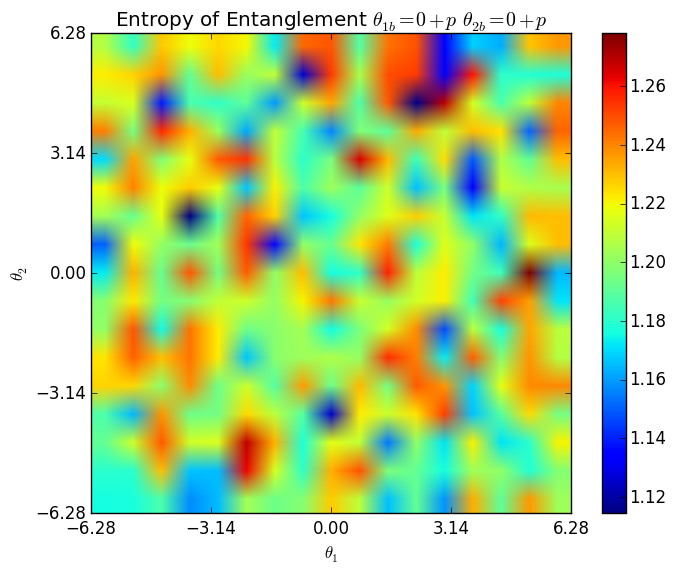

In [22]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title(L"Entropy of Entanglement $\theta_{1b}=0+p$ $\theta_{2b}=0+p$ ")
savefig("EntropyofEntanglement_disorder12.pdf")

In [11]:
#loop through single particle split step walk
#t1a = [0 0 pi/2 0 0 -pi/2]
t1a = -2*pi:pi/4:2*pi
t2a = -2*pi:pi/4:2*pi
#t2a = [pi/2 pi/2+0.1  0 pi/2 0 pi/2] 
#t1b = [0 0 pi/2 pi/2 0 -pi/2]
#t2b = [pi/2 pi/2+0.1 0 0 0 pi/2]
Stt = zeros(length(t1a),length(t2a))

for kk in 1:1:length(t1a)
for ll in 1:1:length(t2a)
n = 20
Sa = [State(0,[1 0]')]
Sb = [State(0,[0 1]')]
#Sa2 = [State(0,[0 1]')]
#Sb2 = [State(0,[1 0]')]
#################################
#Make C1,C2 different for a and b
#################################

St = []
for ii in 1:1:n
    #r = 2*pi*rand(1)-pi
    #C1a = R(t1a[kk]+0.2*pi*rand(1)-0.1*pi)
    #C2a = R(t2a[ll]+0.2*pi*rand(1)-0.1*pi)
    #C1b = R(4*pi*rand(1)-2*pi)
    #C2b = R(4*pi*rand(1)-2*pi)
    Sa = walkarrayf_disorder(t1a[kk],Sa,tspinup,2)
    Sa = walkarrayf_disorder(t2a[ll],Sa,tspindown,2)
    #Sb = walkarrayf(C1b,Sb,tspinup)
    #Sb = walkarrayf(C2b,Sb,tspindown)
    #Sa2 = walkarrayf(C1a,Sa2,tspinup)
    #Sa2 = walkarrayf(C2a,Sa2,tspindown)
    #Sb2 = walkarrayf(C1b,Sb2,tspinup)
    #Sb2 = walkarrayf(C2b,Sb2,tspindown)
    #Sab = (Sa*Sb)
    #calculate entropy
    spin = [s.spin for s in Sa]
    rhoC = zeros(2,2)
    #print(spin,"\n")
    #print(size(spin,1),"\n")
    for s in spin
        #print(spin[jj])
        psi = [s[1] s[2]]
        #print(psi)
        rhoC = rhoC + float64(psi'*psi)
    end
    lambda = eigvals(rhoC)
    Sl = -lambda.*log(abs(lambda))
    St = vcat(St,sum(Sl[!isnan(Sl)]))
end

Stt[kk,ll] = mean(St)
end    
end



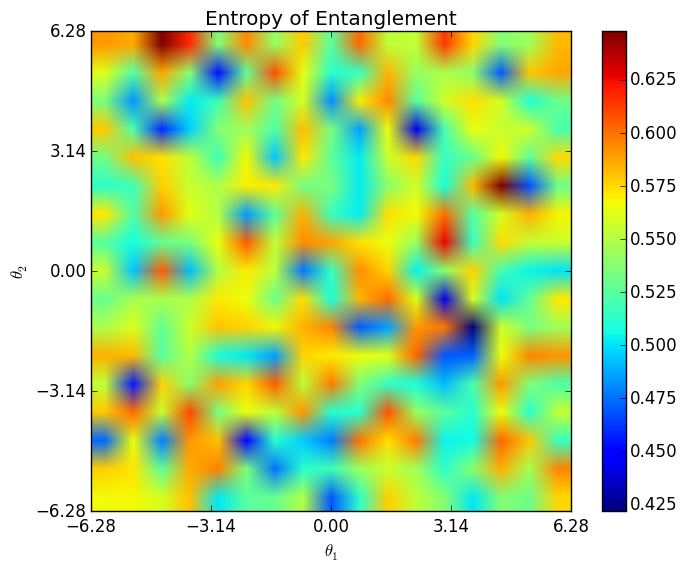

In [12]:
#im = matshow(Stt,cmap="Accent")
fig, ax = subplots()
N=length(t1a)
img = ax[:imshow](Stt,extent=[-2*pi, 2*pi, -2*pi, 2*pi])
xlabel(L"$\theta_1$") 
ylabel(L"$\theta_2$")
#divider = axgrid.make_axes_locatable(ax)
#cax = divider[:append_axes]("right", size="5%", pad=0.05)
ax[:xaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
ax[:yaxis][:set_ticks]([-2*pi, -pi, 0, pi, 2*pi])
colorbar(img)
title("Entropy of Entanglement")
savefig("EntropyofEntanglement_single_disorder3.pdf")

In [23]:
0.5*log2(0.5)

-0.5

In [24]:
eigvals([0.5 0; 0 0.5])

2-element Array{Float64,1}:
 0.5
 0.5